# DSI 19 Capstone Project - Business Newsletter Case Study

For this project I was given access to several company business dashboards and asked to draw some insights from the available data. This project focusses on the newsletter data.

Based on the data available and the business focus being on driving traffic to their website, I focussed on seeing if a keyword in the subject of the newsletter has any influence in the number of clicks and opens that email would receive. We will take a Natural Language Processing approach to explore this.

#### Shortcuts:

<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-&-Functions" data-toc-modified-id="Import-Packages-&-Functions-1">Import Packages & Functions</a></span>
<li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1">Load Data</a></span>
<li><span><a href="#EDA-&-Feature-Extraction" data-toc-modified-id="EDA-&-Feature-Extraction-1">EDA & Feature Extraction</a></span>
<li><span><a href="#Visualization" data-toc-modified-id="Visualization-1">Visualization</a></span>
<li><span><a href="#Modelling" data-toc-modified-id="Modelling-1">Modelling</a></span>
<li><span><a href="#Results" data-toc-modified-id="Results-1">Results</a></span>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1">Conclusion</a></span>

#### Import Packages & Functions

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
import joblib
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import plot_roc_curve
from sklearn import set_config, naive_bayes

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import scikitplot as skplt

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

def stem_sentences(sentence):
    """
    This function takes a full sentence, splits it into words, 
    stems using the stemmer created outside of the function and joins them back together
    into a sentence format.
    """
    stemmer = PorterStemmer()
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def model_fitter_all_features(model, X, y):
    """
    This function takes a model and the X, y variables.
    It then fits the model using all features and returns CV AUC scores and 
    adds them to a dictionary for future use.
    """
    # Preprocessing to repeat some of our steps from the EDA to "dummify" the 
    # date and text variables
    preprocessing = ColumnTransformer([('time_cat', OneHotEncoder(), ['month']),
                               ('words', CountVectorizer(stop_words=stop), 'stemmed_subject')])

    # Pipeline to sequence the preprocessing with the model
    pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', model)])

    pipeline.fit(X, y)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    print("Cross-validated AUC:", cv_scores)
    print("Mean cross-validated AUC:", cv_scores.mean())
    
    model_dict[str(model) + " - All Features"] = list(cv_scores)

    
def model_fitter_words(model, X, y):
    """
    This function takes a model and the X, y variables.
    It then fits the model using only word features and returns CV AUC scores and 
    adds them to a dictionary for future use.
    """
    
    preprocessing = ColumnTransformer([('words', CountVectorizer(stop_words=stop), 'stemmed_subject')])

    pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', model)])

    pipeline.fit(X, y)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    print("Cross-validated AUC:", cv_scores)
    print("Mean cross-validated AUC:", cv_scores.mean())
    
    model_dict[str(model) + " - Only Words"] = list(cv_scores)

    
def model_fitter_less_words(model, X, y):
    """
    This function takes a model and the X, y variables.
    It then fits the model using maximum 50 word features and returns CV AUC scores and 
    adds them to a dictionary for future use.
    """
    
    preprocessing = ColumnTransformer([('words', CountVectorizer(stop_words=stop, max_features=50), 'stemmed_subject')])

    pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', model)])

    pipeline.fit(X, y)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    print("Cross-validated AUC:", cv_scores)
    print("Mean cross-validated AUC:", cv_scores.mean())
    
    model_dict[str(model) + " - Less Words"] = list(cv_scores)
    
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### Load Data

The data was collected via the newsletter dashboard and downloaded as one file for all sent newsletters to date.

In [2]:
df = pd.read_csv('../data/newsletter/newsletter_data.csv')   

Reformat the column titles to something more Python friendly. Convert to lower case and removed spacing.

In [3]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '')

This is what the data looks like:

In [4]:
df.head(2)

namefrom sendingdate                                            subject  \
0  Company 1  28-09-2021  Newsletter Company 1 Exclusiva: Diplo lança no...   
1  Company 2  24-09-2021  Resumo da semana: Dave Grohl desabafa sobre Ku...   

   sent  nondelivered  hardbounces  softbounces nondeliveredrate  delivered  \
0   416            30            0           30            7.21%        386   
1  7394            61            2           59            0.82%       7333   

   totalopens  ...  clicked clickrate  click-to-openrate  unsubscribed  \
0         119  ...        5     1.30%              7.04%             0   
1         960  ...       99     1.35%             13.87%             2   

  unsubscriptionrate deliveredrate  hardbouncesrate softbouncesrate  \
0                 0%        92.79%               0%           7.21%   
1              0.03%        99.18%            0.03%           0.80%   

  complaints complaintsrate  
0          0             0%  
1          0             0%  

[2 rows x 23 columns]

In [5]:
# 584 newsletters and 23 features
df.shape

(584, 23)

In [6]:
# Notice here that the rates are currently 'objects', we will fix this in the EDA section
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   namefrom            584 non-null    object
 1   sendingdate         584 non-null    object
 2   subject             584 non-null    object
 3   sent                584 non-null    int64 
 4   nondelivered        584 non-null    int64 
 5   hardbounces         584 non-null    int64 
 6   softbounces         584 non-null    int64 
 7   nondeliveredrate    584 non-null    object
 8   delivered           584 non-null    int64 
 9   totalopens          584 non-null    int64 
 10  opened              584 non-null    int64 
 11  uniqueopenrate      584 non-null    object
 12  totalclicked        584 non-null    int64 
 13  clicked             584 non-null    int64 
 14  clickrate           584 non-null    object
 15  click-to-openrate   584 non-null    object
 16  unsubscribed        584 no

#### EDA & Feature Extraction

Converted the date column into datetime features.

In [7]:
# We must include the format argument here otherwise the datetime will be read incorrectly
df['sendingdate'] = pd.to_datetime(df['sendingdate'], format='%d-%m-%Y')

In [8]:
df['day_of_week'] = df['sendingdate'].dt.day_name()
df['month'] = df['sendingdate'].dt.month
df['year'] = df['sendingdate'].dt.year

Create an `openrate` column. The data only came with a `uniqueopenrate` column which only accounts for one open per unique recipient, no matter how many times they may have opened it. The `openrate` column will account for all opens counting also if the same recipient opened the email more than once.

We've taken this step because when researching global email marketing benchmarks there is only reference to an "openrate" but no clarity on whether it is referring to unique opens or all opens. We've gone ahead and made the assumption that if the word "unique" is not present then it is referring to all opens (e.g. counting all the times a user has opened up the same email).

In [9]:
df['openrate'] = df.totalopens/df.delivered

Transform the subject column to something that can be used for modelling later. This was done using a Stemmer with Portuguese & English stopwords and numbers, followed by Count Vectorizer to see what the most common subject words were.

In [10]:
# Here we include the numbers to be removed with stopwords
# We create a list from 0-2023 to acheive this
stop_numbers = []
counter = 0

for i in range(0, 2023):
    stop_numbers.append(str(counter))
    counter+=1

In [11]:
# We initiate the stemmer and include our stopwords, extending it for English, numbers, 
# and some additional words that do not add much meaning the problem we wish to solve
stemmer = PorterStemmer()
stop = stopwords.words('portuguese')
stop.extend(stopwords.words('english'))
stop.extend(stop_numbers)
stop.extend(['mai', 'semana', 'notícia'])

In [12]:
# stem_sentences function is initiated with packages at the top of this notebook
# We use this function on the subject of the email
df['stemmed_subject'] = df.subject.apply(stem_sentences)

In [13]:
# Initiate the CountVectorizer with our custom stopwords
cvec = CountVectorizer(stop_words=stop)

In [14]:
cvec_fittransform = cvec.fit_transform(df.stemmed_subject)

In [15]:
# Put the count vectorized data into a dataframe for better viewing
df_cvec = pd.DataFrame(cvec_fittransform.toarray(),
                  columns=cvec.get_feature_names())

In [16]:
# Here we sum each row of the count vectorized dataframe to find the frequency of words
# The output here is the list of words from most frequent to least
total = df_cvec.sum(axis=0)
total.sort_values(ascending=False)

compani      209
escolhido    159
playlist     158
veja         158
lida          91
            ... 
lineup         1
chance         1
lion           1
lips           1
legend         1
Length: 1437, dtype: int64

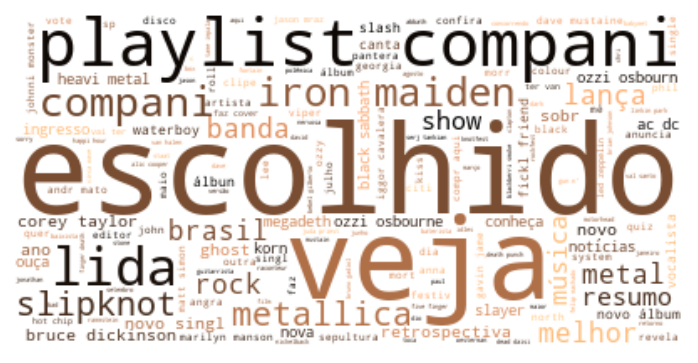

In [17]:
# Going back to the stemmed email subjects before they are count vectorized, we join each
# row to create one text variable for the full data set and create a wordcloud to acheive
# a similar result as the above

text = ' '.join(df['stemmed_subject'])
wordcloud = WordCloud(stopwords=stop, background_color='white', colormap='copper').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.savefig('../plot_pdfs/newsletter/total_wordcloud.pdf')
plt.show();

Upon reviewing the data, we believe there are some outliers that need removing.

There were a few emails that had exceptionally low `sent` numbers compared to the rest, these are not really valuable for testing our theory and we could assume that these were test emails and not part of the normal sending behavior. The distribution of `sent` is also not normal, this could be explained by the different distribution lists being used throughout the account. We perform a statistical ttest with the null hypothesis that the observation is part of the same sample and threshold of 0.05.

Additionally, there were some anomalies with the `nondelivered` data. In some cases it provided a negative `nondelivered` number implying that more emails were delivered than sent - this is not logical so we remove it. In other cases, the `nondelivered` number was very high and sometimes equal to the total sent implying that close to no one received that email - this is not useful to our problem as we need to rely on emails that were sent and received so we remove those too.

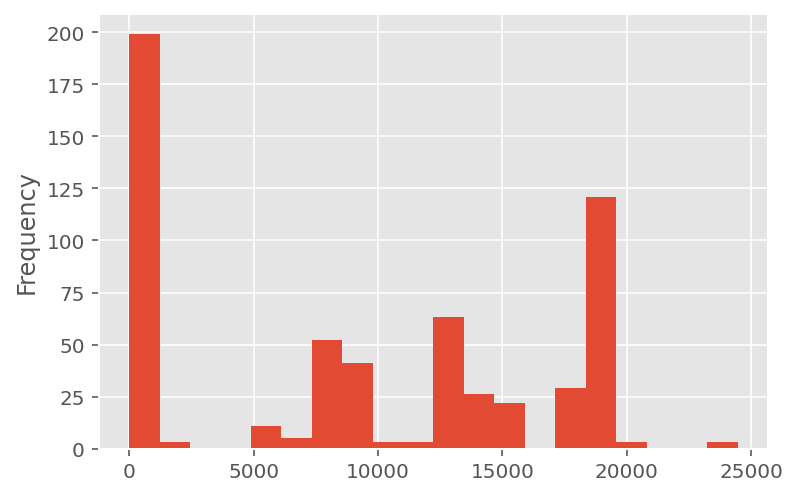

In [18]:
df.sent.plot(kind='hist', bins=20);

The result of the ttest returns a very small pvalue, giving us strong evidence that we can reject the hypothesis and that the observation is not part of the same sample.

In [19]:
stats.ttest_1samp(df.sent, 0)

Ttest_1sampResult(statistic=30.3837238749038, pvalue=2.929583947383146e-122)

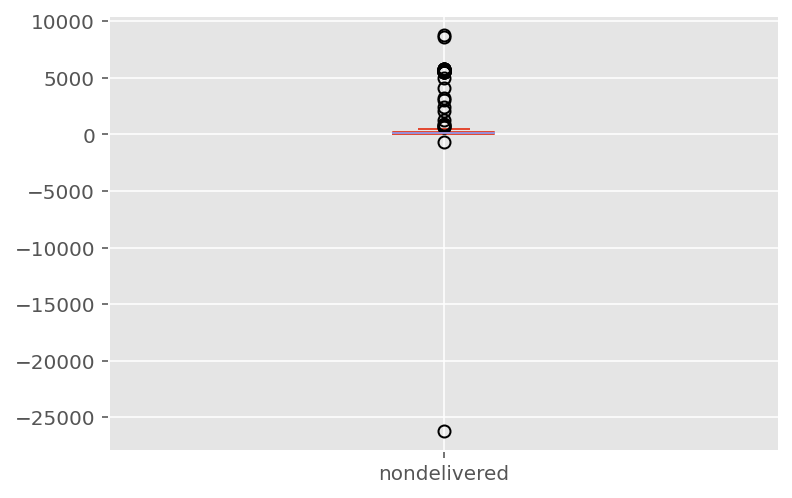

In [20]:
df.nondelivered.plot(kind='box');

In [21]:
df = df[df.sent > 7300]

In [22]:
df = df[df.nondelivered > 0]
df = df[df.nondelivered < 500]

The distribution of `nondelivered` looks much better now.

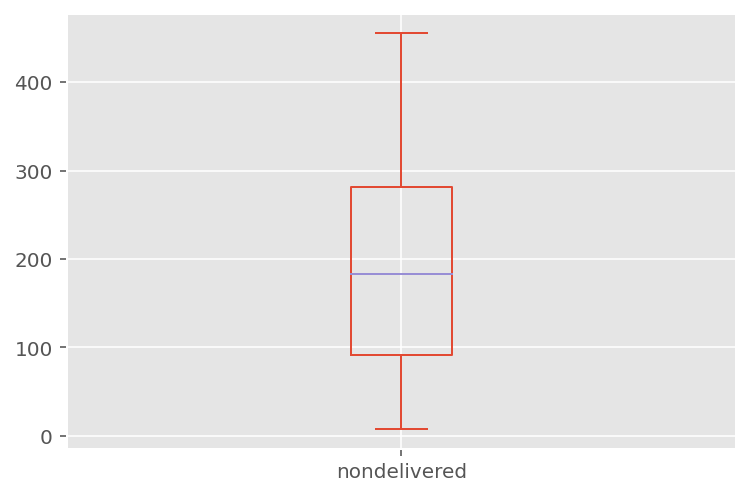

In [23]:
df.nondelivered.plot(kind='box');

The rates are currently object types, we convert them to floats for later plotting and modelling. Our own `openrate` column is not included here as it is already the correct type.

In [24]:
# Select the columns that need correcting
rates = ['nondeliveredrate','uniqueopenrate', 'clickrate',
                                     'click-to-openrate', 'unsubscriptionrate',
                                     'deliveredrate', 'hardbouncesrate','softbouncesrate',
                                     'complaintsrate']

# This for loop goes through each of the aforementioned rate columns, removes the percent
# symbol, and converts the number into a percentage float eg 2% becomes 0.02
for rate in rates:
    df[rate] = df[rate].str.rstrip('%').astype(float) / 100

There are three separate newsletter "senders" : Company 1, Company 2, and Store. The latter only had 1 sent item and was ignored, the other two were separated into their own dataframes.

In [25]:
company1_newsletter = df.loc[lambda x: x['namefrom'] == 'Company 1'].copy()

In [26]:
company2_newsletter = df.loc[lambda x: x['namefrom'] == 'Company 2'].copy()

In [27]:
# We save those dataframes here:

# company1_newsletter.to_csv('../data/newsletter/company1_newsletter.csv', index=False)
# company2_newsletter.to_csv('../data/newsletter/company2_newsletter.csv', index=False)

The word features were extracted using the same methods to see the frequency of words between the two different senders.

In [28]:
company1_newsletter['stemmed_subject'] = company1_newsletter.subject.apply(stem_sentences)
cvec_fittransform = cvec.fit_transform(company1_newsletter.stemmed_subject)
c1_cvec = pd.DataFrame(cvec_fittransform.toarray(),
                  columns=cvec.get_feature_names())
total = c1_cvec.sum(axis=0)
total.sort_values(ascending=False)[:10]

compani        5
glastonburi    2
airbourne      1
indicado       1
wolves         1
veja           1
rock           1
pouco          1
playlist       1
parceiro       1
dtype: int64

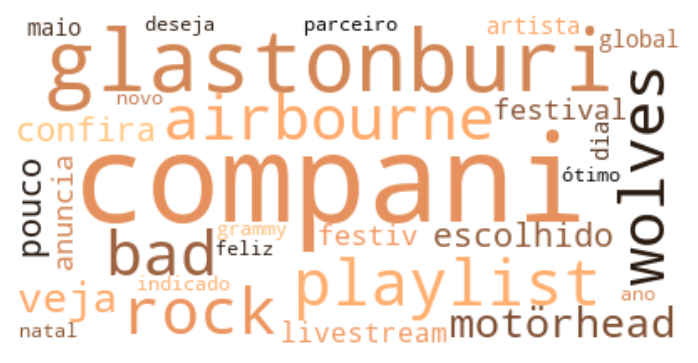

In [29]:
text = ' '.join(company1_newsletter['stemmed_subject'])
wordcloud = WordCloud(stopwords=stop, background_color='white', colormap='copper').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.savefig('../plot_pdfs/newsletter/c1_wordcloud.pdf')
plt.show();

In [30]:
company2_newsletter['stemmed_subject'] = company2_newsletter.subject.apply(stem_sentences)
cvec_fittransform = cvec.fit_transform(company2_newsletter.stemmed_subject)
c2_cvec = pd.DataFrame(cvec_fittransform.toarray(),
                  columns=cvec.get_feature_names())
total = c2_cvec.sum(axis=0)
total.sort_values(ascending=False)[:10]

lida         85
iron         45
maiden       45
slipknot     36
metallica    33
metal        27
melhor       21
brasil       20
ozzi         19
rock         17
dtype: int64

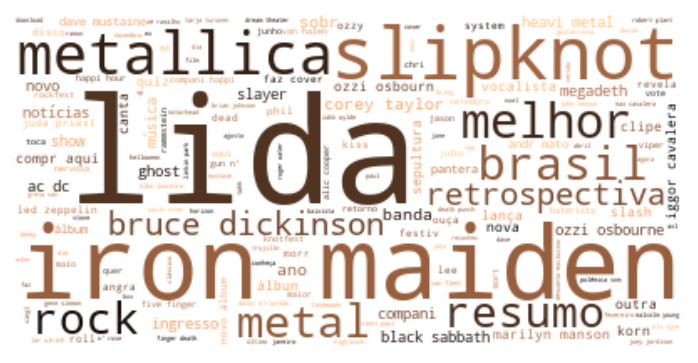

In [31]:
text = ' '.join(company2_newsletter['stemmed_subject'])
wordcloud = WordCloud(stopwords=stop, background_color='white', colormap='copper').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.savefig('../plot_pdfs/newsletter/c2_wordcloud.pdf')
plt.show();

#### Visualization

How many emails did Company 2 send each year?

Here we take a few to see if there are any trends in the number of emails sent per year.

As we can see, 2016 was a slow year but this was the launch of the newsletter so it was not operational for the full year. 2021 is also not complete yet so currently falling behind but the trend for the other years does imply an increase in send outs per year.

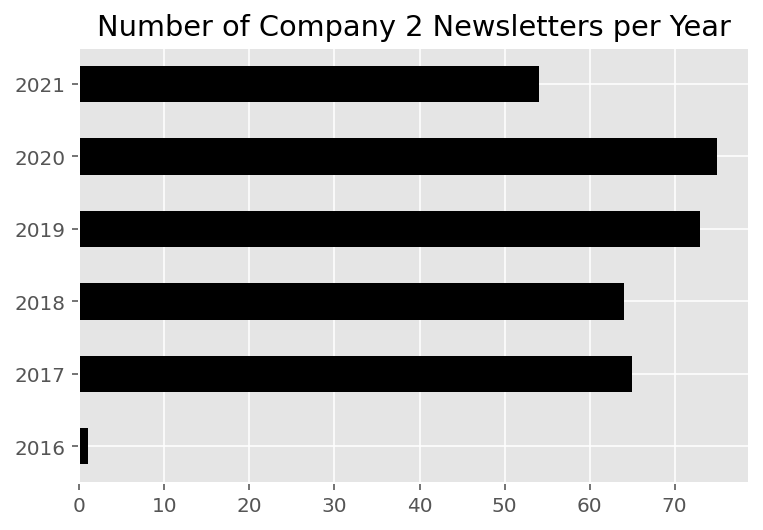

In [32]:
# ax = 
company2_newsletter.groupby('year')['sendingdate'].agg('count').plot(kind = 'barh', 
    color='black', rot=0, 
    title='Number of Company 2 Newsletters per Year', xlabel='');
# ax.figure.savefig('../plot_pdfs/newsletter/c2_emailsperyear.pdf')

What is the monthly activity for Company 2 and how does it compare year on year?

Here we take a closer look at the sending behavior and break it down by month. We can see here that in 2016 they were only sending emails in December. 2021 only goes up to September of this year which is when the data was pulled from the dashboard.

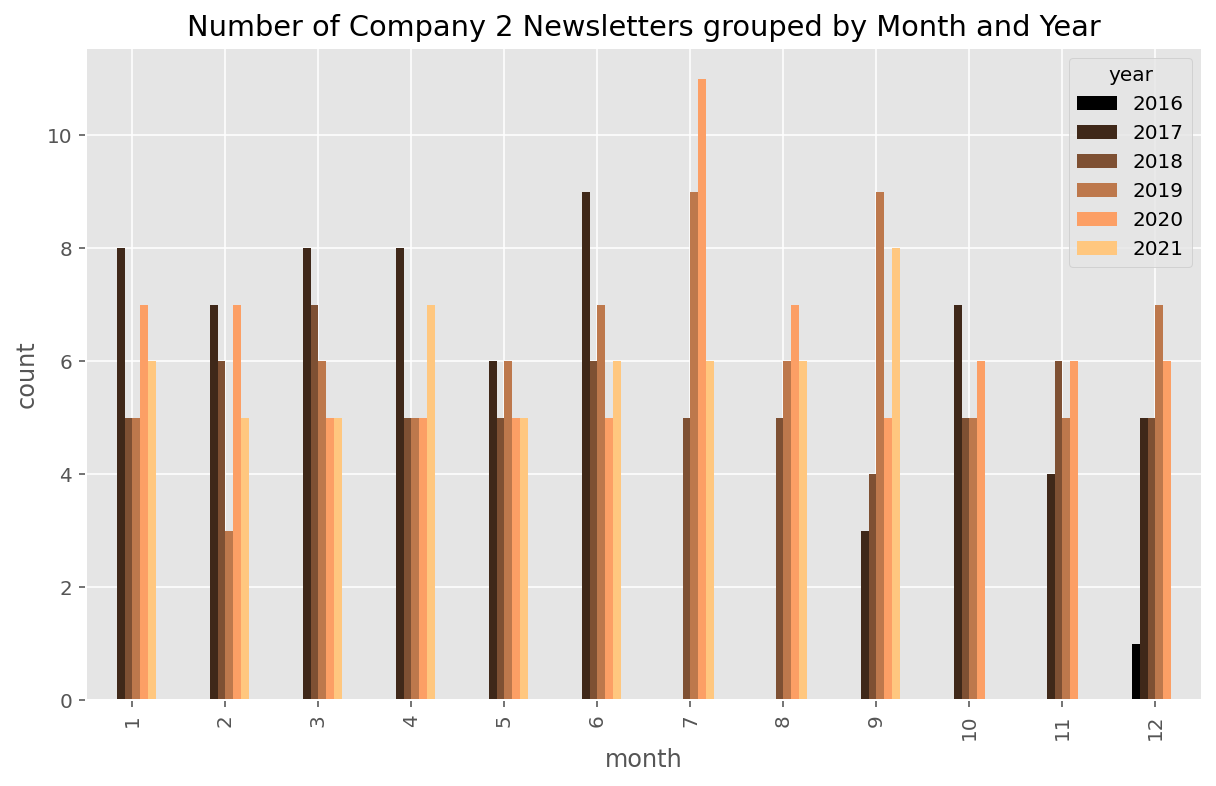

In [33]:
# ax = 
company2_newsletter.groupby(['month', 'year'])['sendingdate'].agg('count').unstack().plot(
    kind='bar', figsize=(10,6), cmap='copper', xlabel='month', ylabel='count', 
    title='Number of Company 2 Newsletters grouped by Month and Year' );
# ax.figure.savefig('../plot_pdfs/newsletter/c2_emailsgrouped.pdf')

Let's look closer. Here we view the overall daily trend.

There is a huge bias for sending emails on a Friday!

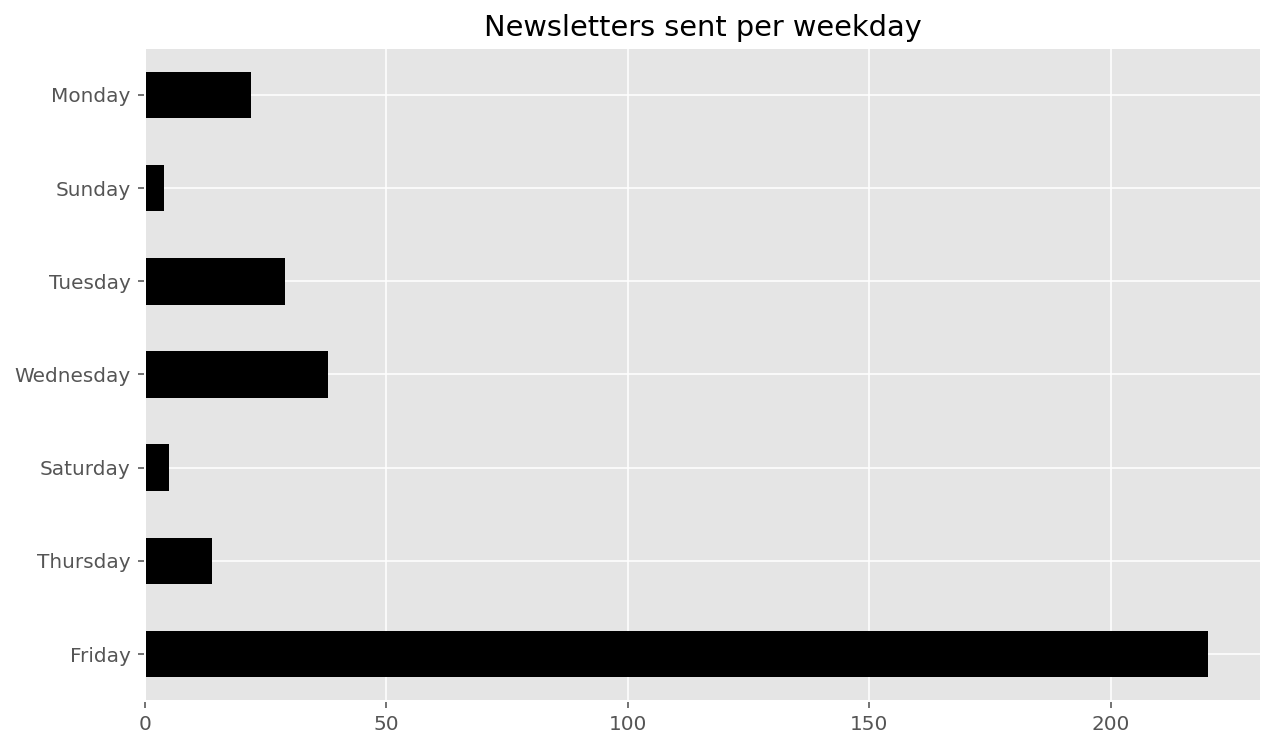

In [34]:
# ax = 
company2_newsletter.groupby('day_of_week', sort=False)['sendingdate'].agg(
    'count').plot(kind = 'barh', figsize = (10,6), cmap='copper', xlabel='',
                 title='Newsletters sent per weekday');
# ax.figure.savefig('../plot_pdfs/newsletter/c2_emailsperday.pdf')

Now let's visualize some of the click & open behaviours and how they compare year on year. First we will remove the incomplete years (2016, 2020).

Definitions:<br>
`opened` and `clicked` count a user that clicks or opens a newsletter at least once. <br>`totalopens` and `totalclicked` counts every instance of the action.

We can infer that many people open an email, but won't necessary click a tracked link in the email. Why? We'll try to answer that with our model.

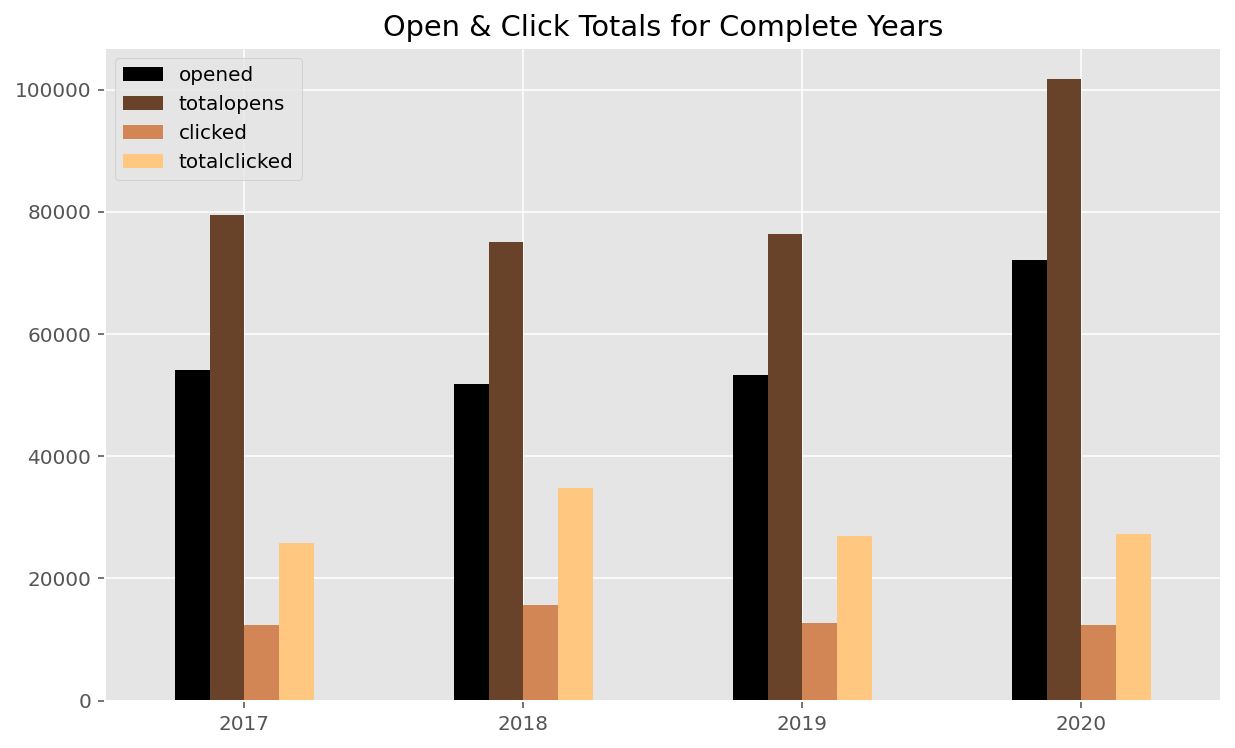

In [35]:
sub = company2_newsletter.loc[(company2_newsletter['year'] != 2016) & 
                              (company2_newsletter['year'] != 2021)]

# ax = 
sub.groupby('year')[['opened', 'totalopens', 'clicked', 'totalclicked']].agg('sum').plot(
    kind = 'bar', figsize = (10,6), cmap='copper', rot=0, xlabel='',
    title='Open & Click Totals for Complete Years');
# ax.figure.savefig('../plot_pdfs/newsletter/c2_openclicks.pdf')

Now we look closer at our target variables.

We check to see if there is a monthly trend and plot the average `openrate` and `click-to-openrate` for the complete years we have. There is no significant trend for `openrate`, but `click-to-openrate` does seem to have some uptick in May, June. This could be worth a closer look but is beyond the scope of this project.

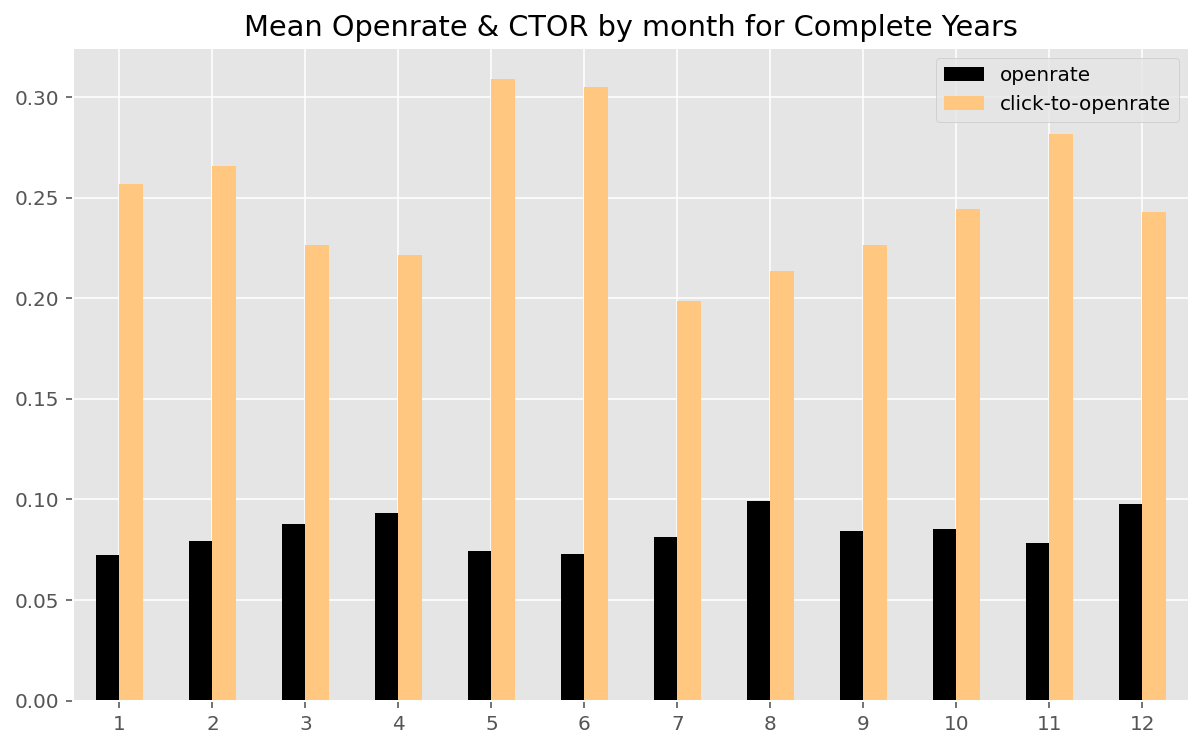

In [36]:
# ax = 
sub.groupby('month')[['openrate', 'click-to-openrate']].agg('mean').plot(
    kind = 'bar', figsize = (10,6), cmap='copper', rot=0, xlabel='',
    title='Mean Openrate & CTOR by month for Complete Years');
# ax.figure.savefig('../plot_pdfs/newsletter/c2_ratesbymonth.pdf')

Finally, we see how this newsletter compares to the global benchmarks for email marketing. Here we do not include the benchmarking for 2021 as that year is not complete yet, and a reminder that our 2016 data is also an incomplete year.

Source: <a href url = https://dma.org.uk/uploads/misc/emailbenchmarkingreport2020.pdf> 2015-2019 Email Benchmark Data </a>
<br>
Source: <a href url = https://www.campaignmonitor.com/resources/guides/global-email-benchmarks-archive/> 2020 Email Benchmark Data </a>
<br>
<br>
Definitions:
- Open Rate : Total number of openings divided by number of emails delivered
- Click Rate : Total number of clicks divided by number of emails delivered
- Click to Open Rate : Total unique clicks divided by total unique opens

A high click-to-open rate indicates that the content resonates strongly with your audience, specifically the ones that open their emails.

Unfortunately, this newsletter is underperforming when it comes to initial open rates, but the ones that do open are loving the content and very click happy!

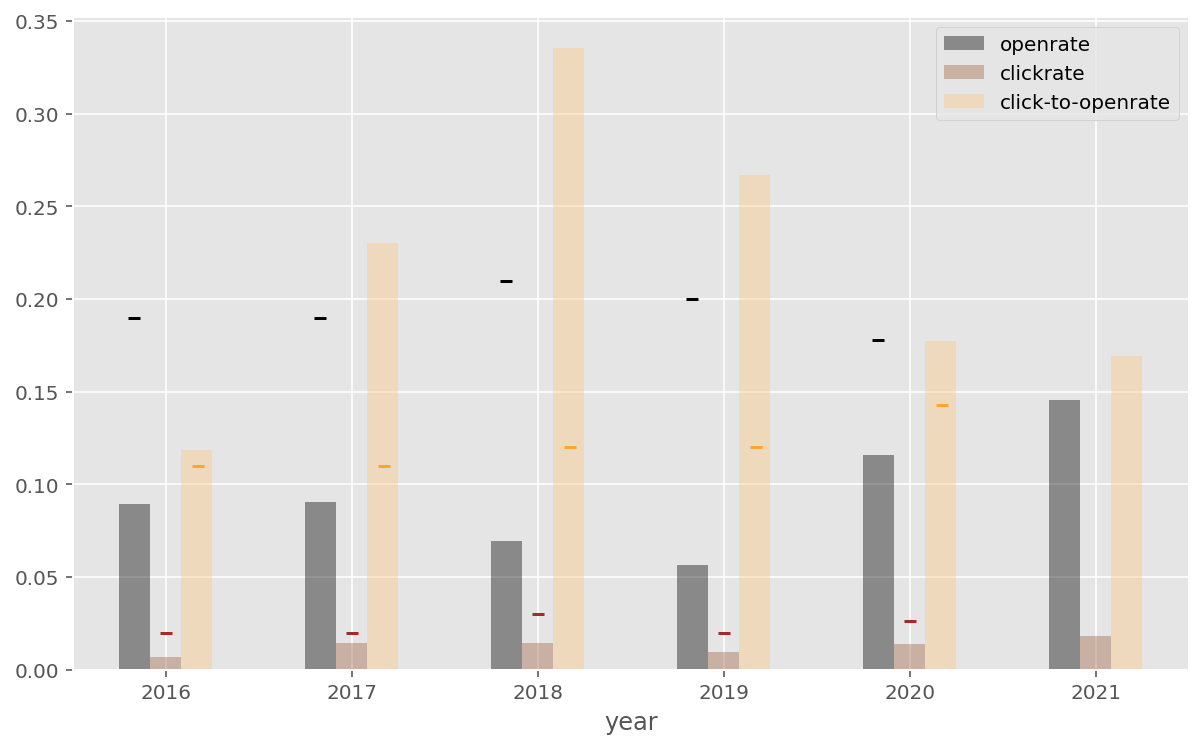

In [37]:
company2_newsletter.groupby('year')[['openrate', 'clickrate','click-to-openrate']].agg('mean').plot(
    kind='bar', figsize = (10,6), alpha=0.4, rot=0, cmap='copper');

#Open Rate Benchmarks:
plt.scatter([-0.17, 0.83, 1.83, 2.83, 3.83], [0.19, 0.19, 0.21, 0.2, 0.178], c='black', marker='_');

#Click Rate Benchmarks:
plt.scatter([0, 1, 2, 3, 4], [0.02, 0.02, 0.03, 0.02, 0.026], c='brown', marker='_');

#Click-to-open Rate Benchmarks:
plt.scatter([0.17, 1.17, 2.17, 3.17, 4.17], [0.11, 0.11, 0.12, 0.12, 0.143], c='darkorange', marker='_');

# plt.savefig('../plot_pdfs/newsletter/c2_benchmark.pdf')


### Modelling

We would like to see if a particular subject or "word" will generate a better `click-to-openrate` or `open-rate`. `clickrate` would also be interesting but as the range of that rate is so small it will be difficult to model on, we will focus on the other two rates.

First, we create a flag for the target variables we want to look at since their range is also small. Anything below the mean will be a "low" rate or 0, and anything above a "high" rate or 1.

In [38]:
ctor_mean = company2_newsletter['click-to-openrate'].mean()
ctor_mean

0.2364081325301203

In [39]:
or_mean = company2_newsletter['openrate'].mean()
or_mean

0.09359760152843752

In [40]:
company2_newsletter['ctor_flag'] = np.where(company2_newsletter['click-to-openrate'] >= ctor_mean, 1, 0)
company2_newsletter['or_flag'] = np.where(company2_newsletter['openrate'] >= or_mean, 1, 0)

We also create an empty dictionary where we will save the modelling scores.

In [41]:
model_dict = {}

#### Target : High click-to-open rate

Using `month`, and `stemmed_subject` as predictor variables.

Note we are not using `day_of_week` as we know most of the newsletters were sent on a Friday.

In [42]:
X = company2_newsletter[['month', 'stemmed_subject']].copy()
y = company2_newsletter['ctor_flag'].copy()

The baseline is 45.7% for a high CTOR.

In [43]:
y.value_counts(normalize=True)

0    0.542169
1    0.457831
Name: ctor_flag, dtype: float64

We use `ColumnTransformer` and `Pipeline` to set up our model with the correct features.

Note that we do not perform a `train_test_split` as our dataset is too small. Keep this in mind when reviewing the scores.

As we will be repeating the process, the pipeline, fitting, and scoring have been defined within a three functions at the start of this notebook.

`model_fitter_all_features` uses all our features (month and words).<br>
`model_fitter_words` uses only word features.<br>
`model_fitter_less_words` uses a maximum of 50 word features.

The cross-validated scoring has been adjusted to 'roc_auc' as this is a classification problem and we want to measure the models ability to distinguish between the two classes we have created (1 or high, and 0 or low). 

We will run the following models:
- LogisticRegression<br>
- DecisionTreeClassifier<br>
- RandomForestClassifier<br>
- KNN Classifier<br>
- Naive Bayes Bernoulli<br>
- Naive Bayes Multinomial

In [44]:
#image portraying the pipeline sequence when using all features

<div>
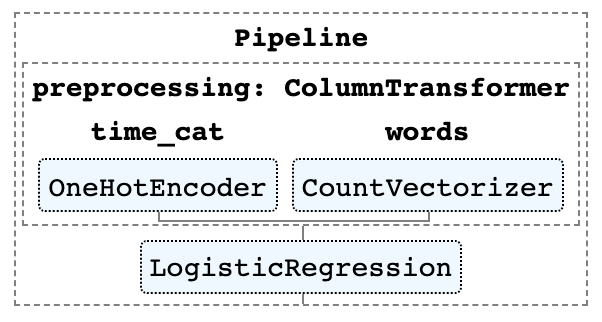
</div>

In [45]:
print("Logistic Regression - All Features:")
model_fitter_all_features(LogisticRegression(), X, y)
print("")
print("Decision Tree - All Features:")
model_fitter_all_features(DecisionTreeClassifier(), X, y)
print("")
print("Random Forest - All Features:")
model_fitter_all_features(RandomForestClassifier(), X, y)
print("")
print("KNN - All Features:")
model_fitter_all_features(KNeighborsClassifier(), X, y)
print("")
print("NBB - All Features:")
model_fitter_all_features(naive_bayes.BernoulliNB(), X, y)
print("")
print("NBM - All Features:")
model_fitter_all_features(naive_bayes.MultinomialNB(), X, y)
print("")

Logistic Regression - All Features:
Cross-validated AUC: [0.6702509  0.91577061 0.63796296 0.66574074 0.77685185]
Mean cross-validated AUC: 0.73331541218638

Decision Tree - All Features:
Cross-validated AUC: [0.6702509  0.68369176 0.59166667 0.66944444 0.63333333]
Mean cross-validated AUC: 0.6496774193548387

Random Forest - All Features:
Cross-validated AUC: [0.72625448 0.87634409 0.59953704 0.66805556 0.75648148]
Mean cross-validated AUC: 0.7253345280764636

KNN - All Features:
Cross-validated AUC: [0.60842294 0.84767025 0.64490741 0.65324074 0.71851852]
Mean cross-validated AUC: 0.6945519713261648

NBB - All Features:
Cross-validated AUC: [0.69175627 0.88888889 0.56944444 0.66296296 0.74722222]
Mean cross-validated AUC: 0.7120549581839903

NBM - All Features:
Cross-validated AUC: [0.68817204 0.88530466 0.56574074 0.66388889 0.74814815]
Mean cross-validated AUC: 0.7102508960573477



This model is difficult to interpret given the number of features.
Additionally, and also as expected with a small data-set, we can see from the CV AUC scoring that we have high variance. We will try to correct this by reducing the features. Let's start with removing `month`.

In [46]:
X = company2_newsletter[['stemmed_subject']].copy()

In [47]:
print("Logistic Regression - Only Words:")
model_fitter_words(LogisticRegression(), X, y)
print("")
print("Decision Tree - Only Words:")
model_fitter_words(DecisionTreeClassifier(), X, y)
print("")
print("Random Forest - Only Words:")
model_fitter_words(RandomForestClassifier(), X, y)
print("")
print("KNN - Only Words:")
model_fitter_words(KNeighborsClassifier(), X, y)
print("")
print("NBB - Only Words:")
model_fitter_words(naive_bayes.BernoulliNB(), X, y)
print("")
print("NBM - Only Words:")
model_fitter_words(naive_bayes.MultinomialNB(), X, y)
print("")

Logistic Regression - Only Words:
Cross-validated AUC: [0.70250896 0.93996416 0.63888889 0.69537037 0.78472222]
Mean cross-validated AUC: 0.7522909199522103

Decision Tree - Only Words:
Cross-validated AUC: [0.74641577 0.68145161 0.54722222 0.65       0.77777778]
Mean cross-validated AUC: 0.680573476702509

Random Forest - Only Words:
Cross-validated AUC: [0.69713262 0.91532258 0.55787037 0.6625     0.76111111]
Mean cross-validated AUC: 0.7187873357228195

KNN - Only Words:
Cross-validated AUC: [0.67786738 0.78673835 0.64444444 0.5712963  0.68148148]
Mean cross-validated AUC: 0.6723655913978495

NBB - Only Words:
Cross-validated AUC: [0.7078853  0.90681004 0.57037037 0.70833333 0.74305556]
Mean cross-validated AUC: 0.7272909199522104

NBM - Only Words:
Cross-validated AUC: [0.70250896 0.89874552 0.56296296 0.70555556 0.74027778]
Mean cross-validated AUC: 0.722010155316607



The variance is still there. Let's try to reduce the number of word features now using the `max_features` argument in the `CountVectorizer`. Recall are first model had 928 features, we removed the day & month features and now we are reducing the word features to a maximum of 50.

In [48]:
print("Logistic Regression - Less Words:")
model_fitter_less_words(LogisticRegression(), X, y)
print("")
print("Decision Tree - Less Words:")
model_fitter_less_words(DecisionTreeClassifier(), X, y)
print("")
print("Random Forest - Less Words:")
model_fitter_less_words(RandomForestClassifier(), X, y)
print("")
print("KNN - Less Words:")
model_fitter_less_words(KNeighborsClassifier(), X, y)
print("")
print("NBB - Less Words:")
model_fitter_less_words(naive_bayes.BernoulliNB(), X, y)
print("")
print("NBM - Less Words:")
model_fitter_less_words(naive_bayes.MultinomialNB(), X, y)
print("")

Logistic Regression - Less Words:
Cross-validated AUC: [0.69086022 0.9422043  0.64490741 0.66805556 0.75648148]
Mean cross-validated AUC: 0.7405017921146954

Decision Tree - Less Words:
Cross-validated AUC: [0.55824373 0.65905018 0.53518519 0.61435185 0.73240741]
Mean cross-validated AUC: 0.619847670250896

Random Forest - Less Words:
Cross-validated AUC: [0.69982079 0.83557348 0.54953704 0.62685185 0.76666667]
Mean cross-validated AUC: 0.695689964157706

KNN - Less Words:
Cross-validated AUC: [0.54973118 0.77553763 0.63842593 0.65092593 0.7       ]
Mean cross-validated AUC: 0.6629241338112306

NBB - Less Words:
Cross-validated AUC: [0.73297491 0.89471326 0.58842593 0.6412037  0.74814815]
Mean cross-validated AUC: 0.7210931899641576

NBM - Less Words:
Cross-validated AUC: [0.76433692 0.85349462 0.62268519 0.61342593 0.73888889]
Mean cross-validated AUC: 0.7185663082437277



<br>
<br>
Now that we have made several models, we will compare and interpret the AUC scoring. We do this by converting the scores we saved in a dictionary into a dataframe and extracting the min, max, mean, and variance for plotting.

In [49]:
# Save our model scores into a dataframe
df_model = pd.DataFrame.from_dict(model_dict)

In [50]:
# Create another dataframe that will be used for plotting
# We creat our columns that name the model, give the min, max, and mean score as well as
# the difference between the min and max (the variance)
df_plot = pd.DataFrame()
df_plot['models'] = list(df_model.columns)
df_plot['min'] = list(df_model.min())
df_plot['max'] = list(df_model.max())
df_plot['mean'] = list(df_model.mean())
df_plot['variance'] = df_plot['max'] - df_plot['min']

# Resent the index so that the model names are shown in the plot
df_plot.set_index('models', inplace=True)

# Sort by the mean
df_plot.sort_values(by='mean', ascending=True, inplace=True)

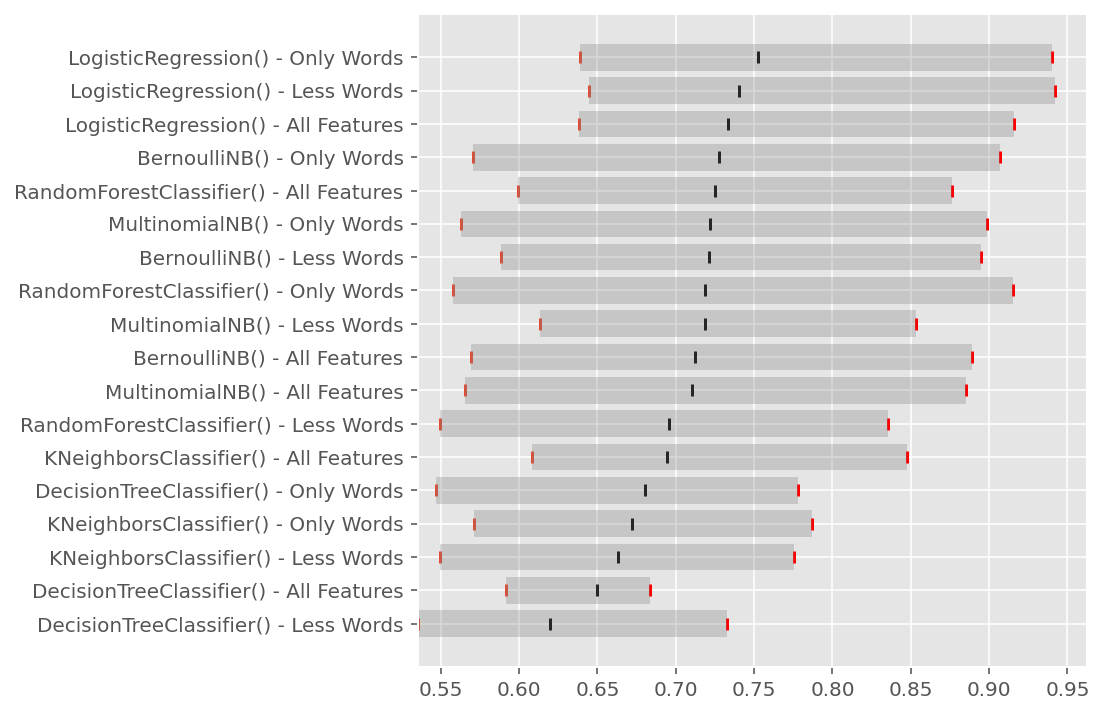

In [51]:
# Adjust the size of our plot
plt.figure(figsize=(6,6))

# Plot the minimum values
plt.scatter(df_plot['min'], df_plot.index, marker='|')

# Plot the maximum values
plt.scatter(df_plot['max'], df_plot.index, marker='|', color='red')

# Plot the mean values
plt.scatter(df_plot['mean'], df_plot.index, marker='|', color='black');

# And fill in the space inbetween min and max, or plotting the variance
plt.barh(df_plot.index, left=df_plot['min'], width=df_plot['variance'], alpha=0.3, color='grey');

# plt.savefig('../plot_pdfs/newsletter/score_comparison_plot.pdf')

If we look at mean alone, the better model would be the Logistic Regression using only word features. Alternatively, if we look at variance alone, the better model would be the Decision Tree with only word features.

We want to maximize the mean and minimize the variance. Looking at both of these metrics, we can determine that the Logistic Regression using all features is the better model here.

Let's look at the features from our best model.

In [52]:
#Reload & save the model

X = company2_newsletter[['month', 'stemmed_subject']].copy()
y = company2_newsletter['ctor_flag'].copy()

preprocessing = ColumnTransformer([('time_cat', OneHotEncoder(), ['month']),
                               ('words', CountVectorizer(stop_words=stop), 'stemmed_subject')])

pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                          ('model', LogisticRegression())])

pipeline.fit(X, y)

joblib.dump(pipeline, '../saved_models/newsletter/pipeline_ctor.jlib')

['../saved_models/newsletter/pipeline_ctor.jlib']

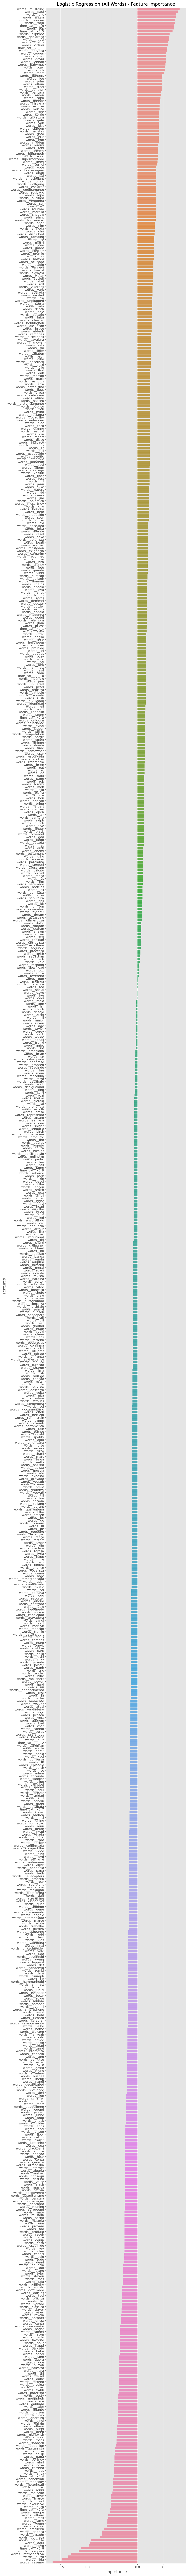

In [53]:
# Create a dataframe extracting the feature names and coeficients from the pipeline
df_best = pd.DataFrame({'features':pipeline.steps[0][1].get_feature_names(), 'importance':pipeline.steps[1][1].coef_[0]})

# Sort the values by the coefficients
df_best.sort_values(by='importance', ascending=False, inplace=True)

# Adjust the size of our plot
plt.figure(figsize=(8,150))

#Create a bar plot visualising our features
sns.barplot(x=df_best.importance, y=df_best.features)

# Adjust the titles
plt.title('Logistic Regression (All Words) - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features');
# plt.savefig('../plot_pdfs/newsletter/final_features.pdf')

#### Target : High open rate

In the OR notebook we ran the same 18 models above for the `openrate` variable. Below is a recap of the scores and features of the best model.

The results were similar however Random Forest came up as the best model in that scenario.

Here is a visual representing the scores for the `openrate`:

<div>
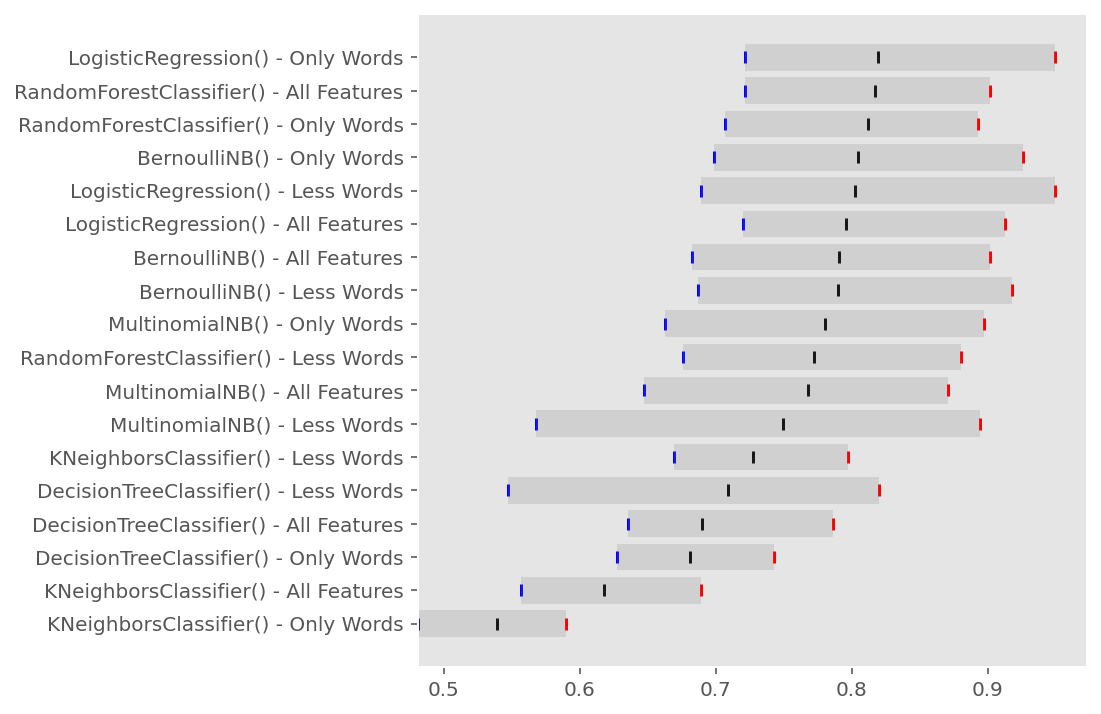
</div>

And these are the top features from the Random Forest with the `openrate` target variable:

In [54]:
df_openrate = pd.read_csv('../data/newsletter/openrate_features.csv')

In [55]:
df_openrate.head(10)

features  importance
0           words__lida    0.049658
1         words__resumo    0.048614
2  words__retrospectiva    0.037931
3           words__rock    0.015643
4        time_cat__x0_8    0.015348
5           words__show    0.014086
6          words__heavi    0.013360
7       words__slipknot    0.012996
8           words__sobr    0.012396
9           words__novo    0.011769

Compare to the top 20 and bottom 10 from the Logistic Regression with the `click-to-open rate` target variable.

In [56]:
df_best.head(20)

features  importance
550   words__mustaine    0.816873
607       words__paul    0.785160
29        words__alic    0.749247
38       words__angra    0.743444
852    words__turunen    0.725263
814      words__tarja    0.725263
5      time_cat__x0_6    0.711449
836        words__top    0.708199
4      time_cat__x0_5    0.680807
777   words__slipknot    0.623582
197  words__declaraçõ    0.611170
375      words__heavi    0.610773
517      words__matos    0.589297
882    words__virtuai    0.588236
10    time_cat__x0_11    0.579197
559    words__nervosa    0.572195
167     words__cooper    0.562201
519        words__max    0.560486
189      words__david    0.557695
476     words__lennon    0.557592

In [57]:
df_best.tail(10)

features  importance
161        words__conheça   -0.730070
401       words__ingresso   -0.907090
46            words__aqui   -0.924426
574           words__novo   -0.951219
7          time_cat__x0_8   -1.101963
150        words__compani   -1.144449
693  words__retrospectiva   -1.289294
584          words__outra   -1.352727
484           words__lida   -1.468387
689         words__resumo   -1.651384

### Results

It seems the words `resumo` and `retrospectiva` have some influence on our target variables.

We take a closer look but creating a flag and running a statistical test to validate the results of our modelling.

In [58]:
# Create new columns with a flag indicating whether the word is contained in that row
company2_newsletter['results_resumo'] = np.where(company2_newsletter.stemmed_subject.str.contains('resumo'), 1, 0)
company2_newsletter['results_retrospectiva'] = np.where(company2_newsletter.stemmed_subject.str.contains('retrospectiva'), 1, 0)


The null hypothesis is that all the data is the same and the segmentation of whether or not our keyword is present is not relevant. The threshold is 0.05.

Our tests on the segmentation of "resumo" and "retrospectiva" and both the `click-to-openrate` and `openrate` indicate that we can reject the hypothesis (pvalue is below the threshold) and that we have successfully found a segmentation of the dataset.

In [59]:
# Run a test to see if we have found user segmentation based on behaviors around our keywords
# Here it is a test on "resumo" and the CTOR


# The p-value is below our threshold and we can reject our hypothesis
stats.ttest_ind(company2_newsletter[company2_newsletter.results_resumo == 0]['click-to-openrate'], company2_newsletter[company2_newsletter.results_resumo == 1]['click-to-openrate'])


Ttest_indResult(statistic=1.9905386986807716, pvalue=0.04735616813923224)

In [60]:
# Here we test on "resumo" and the openrate

# Once again the p-value is below our threshold
stats.ttest_ind(company2_newsletter[company2_newsletter.results_resumo == 0]['openrate'], company2_newsletter[company2_newsletter.results_resumo == 1]['openrate'])



Ttest_indResult(statistic=-4.6595711896512855, pvalue=4.603481371167992e-06)

In [61]:
# Here we run the same tests on "retrospectiva", we are below the threshold on both
stats.ttest_ind(company2_newsletter[company2_newsletter.results_retrospectiva == 0]['click-to-openrate'], company2_newsletter[company2_newsletter.results_retrospectiva == 1]['click-to-openrate'])


Ttest_indResult(statistic=4.17158482009211, pvalue=3.8717760120912104e-05)

In [62]:
stats.ttest_ind(company2_newsletter[company2_newsletter.results_retrospectiva == 0]['openrate'], company2_newsletter[company2_newsletter.results_retrospectiva == 1]['openrate'])


Ttest_indResult(statistic=-1.9826901158477468, pvalue=0.04823096424367227)

We visualize this segmentation.

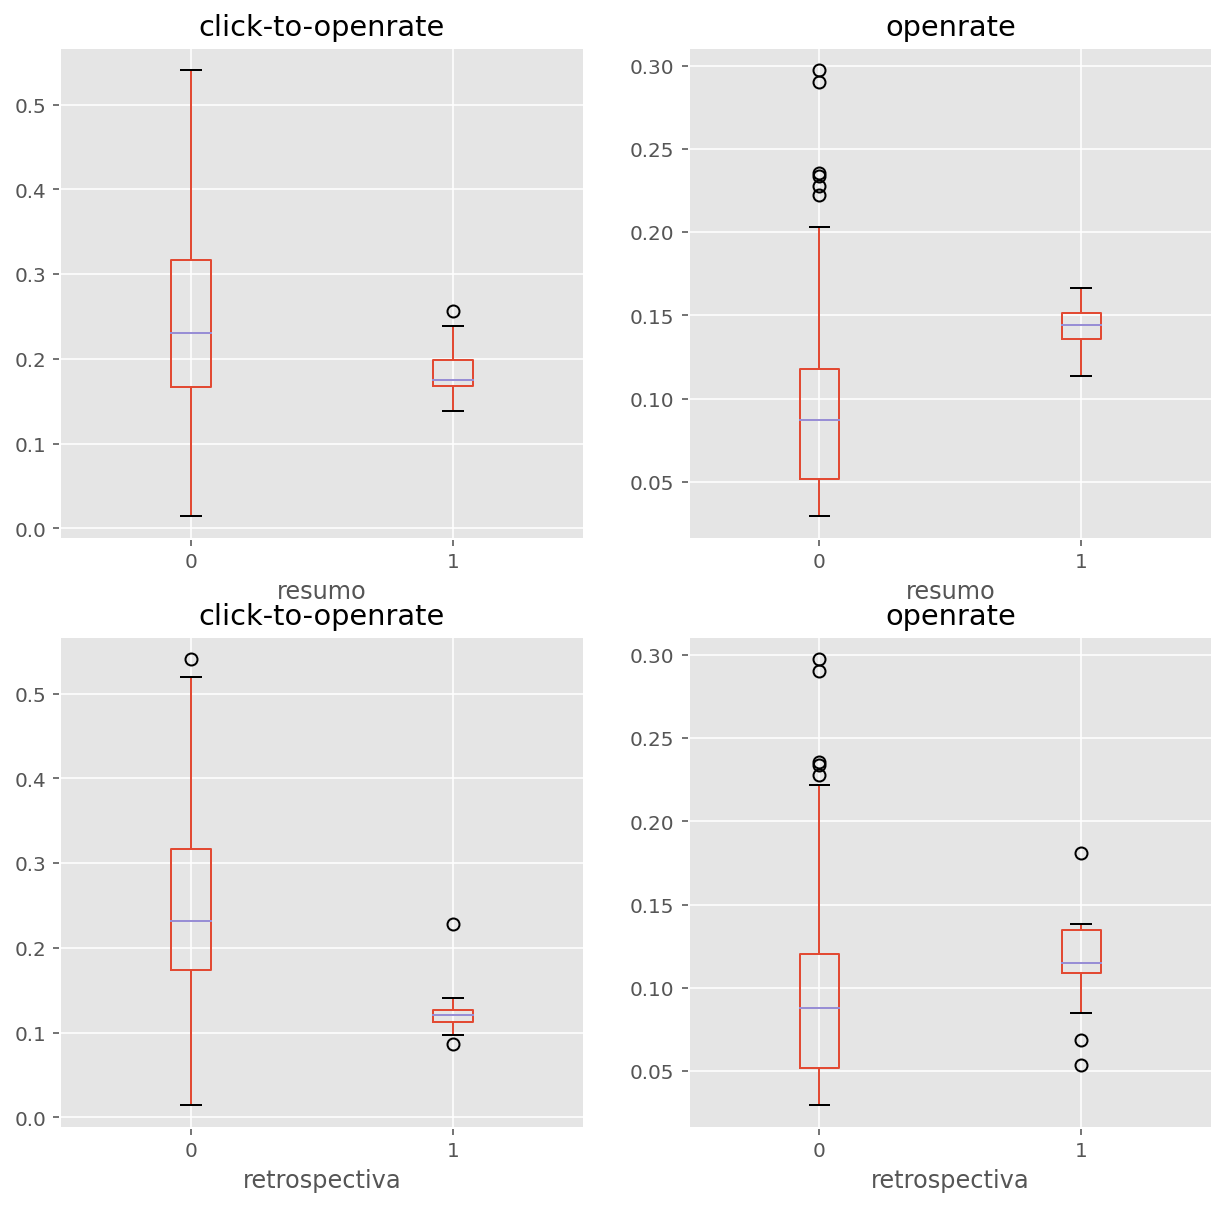

In [63]:
# Create subplot grid
fig, ax = plt.subplots(2, 2, figsize=(10,10))

# Resumo
company2_newsletter.boxplot(column='click-to-openrate', by='results_resumo', ax=ax[0,0])
ax[0,0].set_xlabel('resumo')

company2_newsletter.boxplot(column='openrate', by='results_resumo', ax=ax[0,1])
ax[0,1].set_xlabel('resumo')

# Retrospectiva
company2_newsletter.boxplot(column='click-to-openrate', by='results_retrospectiva', ax=ax[1,0])
ax[1,0].set_xlabel('retrospectiva')

company2_newsletter.boxplot(column='openrate', by='results_retrospectiva', ax=ax[1,1]);
ax[1,1].set_xlabel('retrospectiva');
plt.suptitle('');

# plt.savefig('../plot_pdfs/newsletter/results_boxplots.pdf')

Several of the strongest features are either band or artist names. "Slipknot", for example, comes up as a positive coefficient in our Logistic Regression and a strong feature in our Random Forest. Let's explore some of these in a similar way.

In [64]:
# Create a flag of whether the word appears in the subject
company2_newsletter['results_slipknot'] = np.where(company2_newsletter.stemmed_subject.str.contains('slipknot'), 1, 0)
company2_newsletter['results_nervosa'] = np.where(company2_newsletter.stemmed_subject.str.contains('nervosa'), 1, 0)
company2_newsletter['results_mustaine'] = np.where(company2_newsletter.stemmed_subject.str.contains('mustaine'), 1, 0)
company2_newsletter['results_lennon'] = np.where(company2_newsletter.stemmed_subject.str.contains('lennon'), 1, 0)

In [65]:
# Test for Slipknot

# P-value is below our threshold, so we have another segmentation here
print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_slipknot == 0]['click-to-openrate'], company2_newsletter[company2_newsletter.results_slipknot == 1]['click-to-openrate']))

print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_slipknot == 0]['openrate'], company2_newsletter[company2_newsletter.results_slipknot == 1]['openrate'])
)

Ttest_indResult(statistic=-3.3160074932529153, pvalue=0.0010148103974679885)
Ttest_indResult(statistic=5.117007932680314, pvalue=5.279366367304081e-07)


In [66]:
# Test for Nervosa
print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_nervosa == 0]['click-to-openrate'], company2_newsletter[company2_newsletter.results_nervosa == 1]['click-to-openrate']))

print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_nervosa == 0]['openrate'], company2_newsletter[company2_newsletter.results_nervosa == 1]['openrate'])
)

Ttest_indResult(statistic=-2.131307989204242, pvalue=0.03380239135762428)
Ttest_indResult(statistic=2.250184032592354, pvalue=0.025095580699609744)


In [67]:
# Test for Mustaine
print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_mustaine == 0]['click-to-openrate'], company2_newsletter[company2_newsletter.results_mustaine == 1]['click-to-openrate']))

print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_mustaine == 0]['openrate'], company2_newsletter[company2_newsletter.results_mustaine == 1]['openrate'])
)

Ttest_indResult(statistic=-2.2407597597023634, pvalue=0.025706473683472918)
Ttest_indResult(statistic=1.718076649852435, pvalue=0.08672064062095076)


In [68]:
# Test for Lennon
print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_lennon == 0]['click-to-openrate'], company2_newsletter[company2_newsletter.results_lennon == 1]['click-to-openrate']))

print(stats.ttest_ind(company2_newsletter[company2_newsletter.results_lennon == 0]['openrate'], company2_newsletter[company2_newsletter.results_lennon == 1]['openrate'])
)

Ttest_indResult(statistic=-2.9700200385546047, pvalue=0.003196038512271494)
Ttest_indResult(statistic=1.9687869361924748, pvalue=0.049814078668389106)


Nearly all pvalues are below the threshold again, all but "Mustaine" on the `openrate` variable.

Let's visualize these segments.

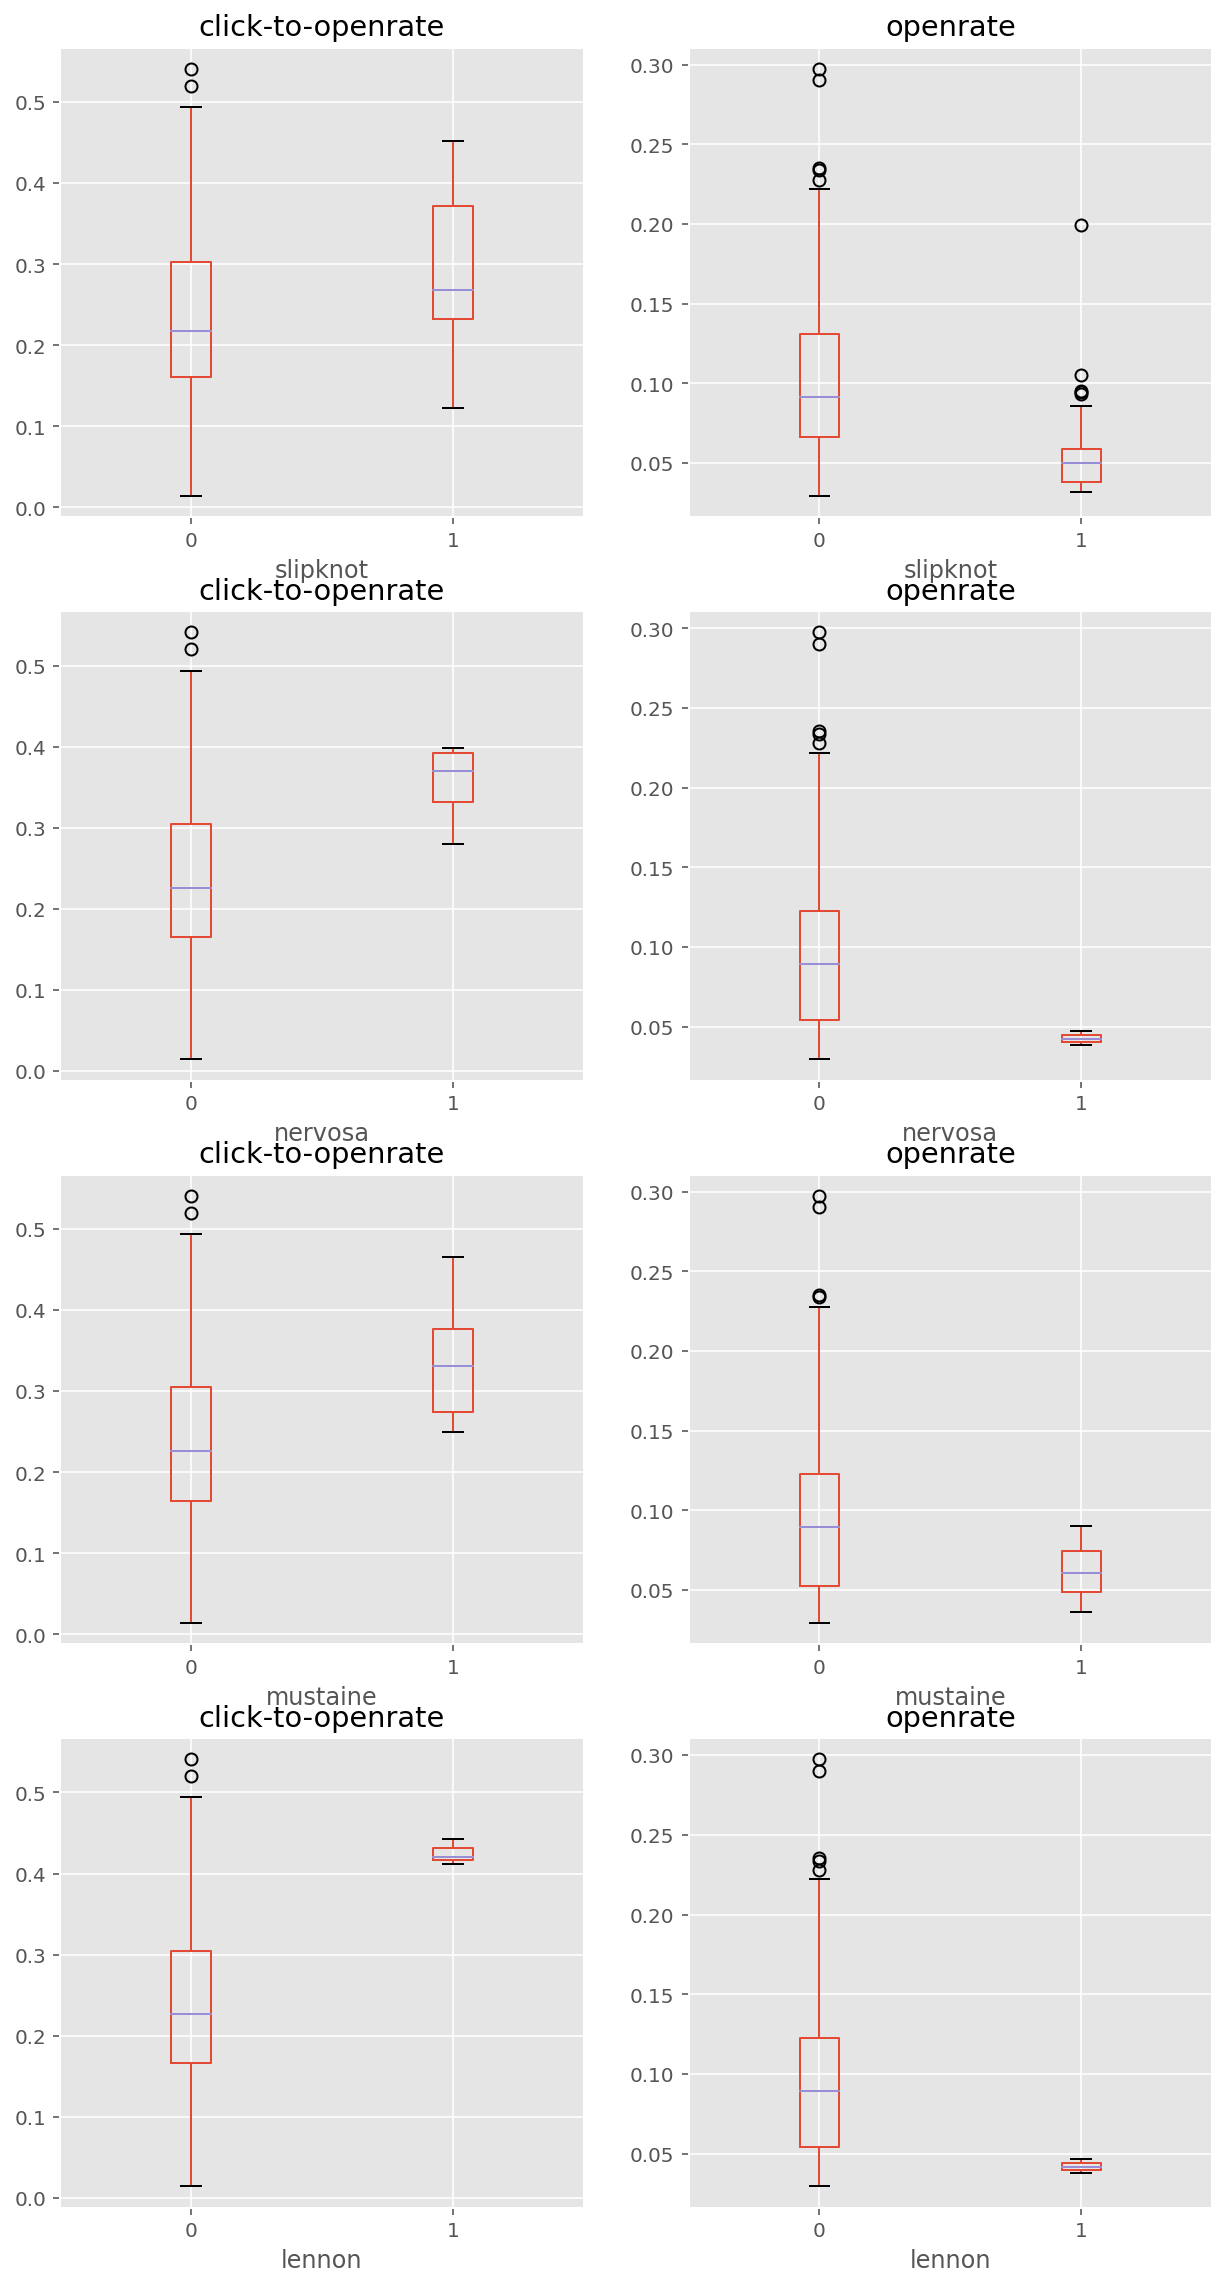

In [69]:
# Create subplot grid
fig, ax = plt.subplots(4, 2, figsize=(10,20))

# Box plots for each keyword - Slipknot
company2_newsletter.boxplot(column='click-to-openrate', by='results_slipknot', ax=ax[0,0])
ax[0,0].set_xlabel('slipknot')

company2_newsletter.boxplot(column='openrate', by='results_slipknot', ax=ax[0,1])
ax[0,1].set_xlabel('slipknot')

# Nervosa
company2_newsletter.boxplot(column='click-to-openrate', by='results_nervosa', ax=ax[1,0])
ax[1,0].set_xlabel('nervosa')

company2_newsletter.boxplot(column='openrate', by='results_nervosa', ax=ax[1,1]);
ax[1,1].set_xlabel('nervosa');

# Mustaine
company2_newsletter.boxplot(column='click-to-openrate', by='results_mustaine', ax=ax[2,0])
ax[2,0].set_xlabel('mustaine')

company2_newsletter.boxplot(column='openrate', by='results_mustaine', ax=ax[2,1]);
ax[2,1].set_xlabel('mustaine');

# Lennon
company2_newsletter.boxplot(column='click-to-openrate', by='results_lennon', ax=ax[3,0])
ax[3,0].set_xlabel('lennon')

company2_newsletter.boxplot(column='openrate', by='results_lennon', ax=ax[3,1]);
ax[3,1].set_xlabel('lennon');
plt.suptitle('');

In all cases, we do see a change in the mean rates when we separate whether or not the keyword was present. Interestingly, the effect is always opposite between `openrate` and `click-to-openrate`. We have not found a keyword that makes both rates go up, it's either one or the other.

We take one more step to validate our model and plot the AUC-ROC curve of our two chosen models, a qualifier that works well with our binary classification needs. It tells us if our model is capable of correctly predicting between the high/low flags we created. A good result means the curve stretches all the way to the top left corner.

In [79]:
# Load the model from newsletter_OR
load_openrate_pipe = joblib.load('../saved_models/newsletter/pipeline_or.jlib')

Here we make re-load the correct variables as we want to plot both top performing models from the two rates here.

In [71]:
X = company2_newsletter[['month', 'stemmed_subject']].copy()

In [72]:
y1 = company2_newsletter['ctor_flag'].copy()

In [73]:
y2 = company2_newsletter['or_flag'].copy()

We visualize the AUC (Area Under the Curve) with `skplt.metrics.plot_roc`.

The correct way of using this metric is with the test set, if you recall we did not do that for the modelling so let's create it here.

In [74]:
# Train test split for the two models and corresponding Y variables
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y1, test_size=0.3, random_state=1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y2, test_size=0.3, random_state=1)


In [80]:
# Refit the model with our training sets
pipeline.fit(X_train_1, y_train_1)
load_openrate_pipe.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('time_cat', OneHotEncoder(),
                                                  ['month']),
                                                 ('words',
                                                  CountVectorizer(stop_words=['de',
                                                                              'a',
                                                                              'o',
                                                                              'que',
                                                                              'e',
                                                                              'é',
                                                                              'do',
                                                                              'da',
                                                                              'em',
             

In [81]:
# Extract the probabilities of your predictions using the test set
proba_ctor = pipeline.predict_proba(X_test_1)
proba_or = load_openrate_pipe.predict_proba(X_test_2)

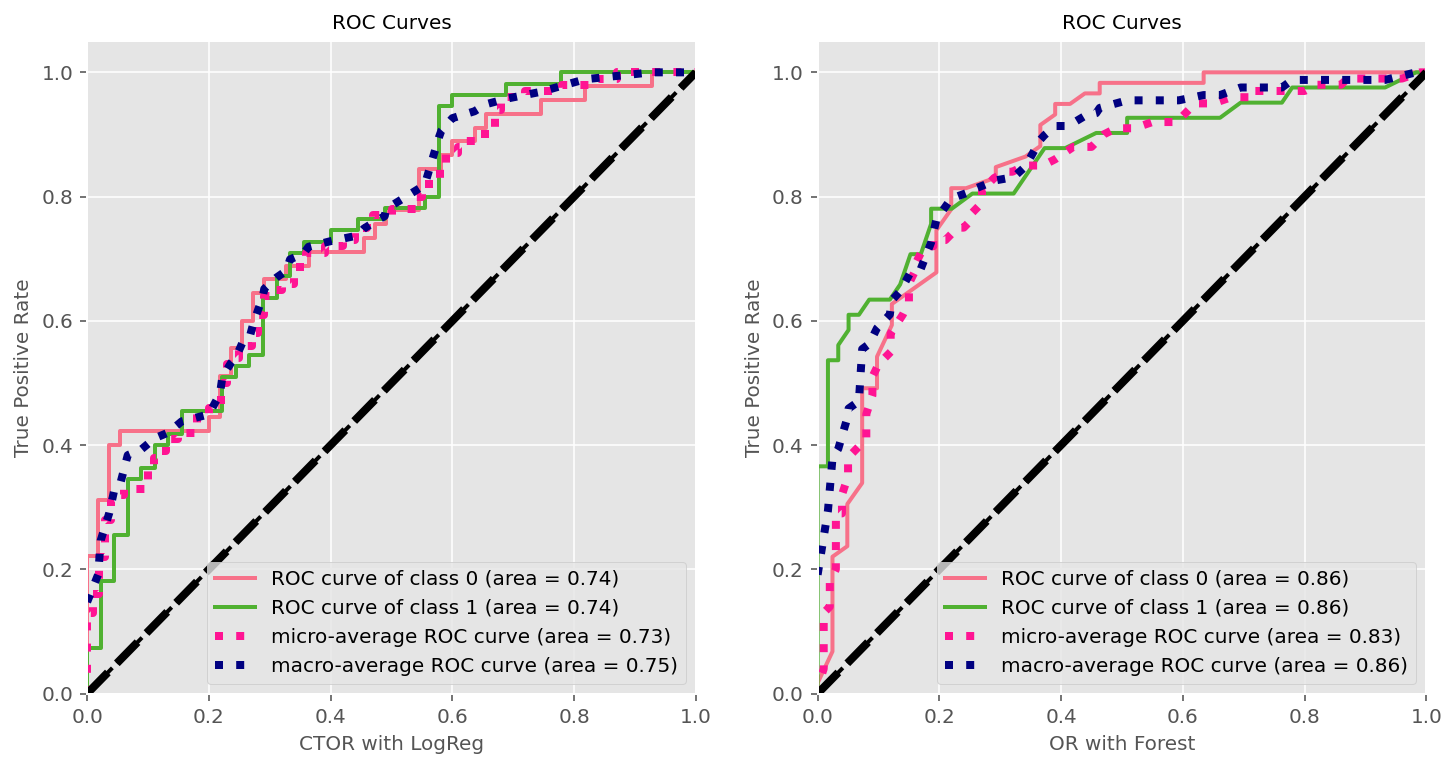

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Logistic Regression - Click-to-openrate
skplt.metrics.plot_roc(y_test_1, proba_ctor, plot_micro=True, plot_macro=True, 
                       title_fontsize=10, text_fontsize=10, cmap=cmap, ax=ax[0])
# plot_roc_curve(pipeline_logreg_all, X_test_1, y_test_1, ax=ax[0])
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('CTOR with LogReg')

# Random Forest - Openrate
skplt.metrics.plot_roc(y_test_2, proba_or, plot_micro=True, plot_macro=True, 
                       title_fontsize=10, text_fontsize=10, cmap=cmap, ax=ax[1])
# plot_roc_curve(load_openrate_pipe, X_test_2, y_test_2, ax=ax[1])
ax[1].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[1].set_xlabel('OR with Forest')

plt.show();
# plt.savefig('../plot_pdfs/newsletter/auc_plots.pdf')

The inference from the above plots is that our `openrate` Random Forest model performed better, however both performed reasonably well and better then our baselines.

Baseline `click-to-openrate`: 0.457831

Baseline `openrate`: 0.430723

### Conclusion

In all cases we were unable to remove the variance in the modelling and after trying various feature reduction methods to do so we can conclude that the issue here is the size of the data set.

The features pulled from our two top models tell us a story. Both indicate "resumo" and "retrospectiva" as important features however with the Logistic Regression we can infer that the relationship there is negative. Upon closer inspection we can infer that these keywords have a positive influence on `openrate` but a negative influence on `click-to-openrate` indicating that readers have no interest in clicking further to the website.

We also investigate some artist names and find further segmentations. In all instances the effect on `openrate` is always opposite to that of `click-to-openrate`.

The problem we set out to answer was to increase clicks to the website from the newsletter. As we didn't model on `clickrate` given the miniscule rate range there we focussed on `openrate` and `click-to-openrate`.

In real terms, the recommendation will need to be based on what the future business strategy will be and what to focus on. Having looked at where the business sits across email marketing benchmarks, perhaps a focus on improving the `openrate` could be a good recommendation since the `click-to-openrate` is over performing. In this case, although our results indicate that a newsletters on "resumo" and "retrospectiva" negatively impact the `click-to-openrate`, it does have a positive impact on `openrate`.

To summarize, if the business wants more people to open their emails then a focus on news recaps may be helpful. Alternative, if they want more people to engage with the content after opening then a focus on breaking news on artists may be helpful.

The caveat remains that these results come from a small dataset with high variance and although we have tested for robustness of the results, there is still room for improvement.

#### Limitations

- Aside from the size of the dataset, the biggest issue faced here is the language barrier given the data is in Portuguese. It is likely that more words can be added into the `stopwords` feature however given the engineer's limited knowledge of the language this was not done.

- A better understanding of email marketing metrics would also be helpful.

#### Further Investigation

- This model can be revisited in the future when more data as available, however given the frequency of the newsletter we would be looking at a wait time of a few years in order to increase the dataset substantially.

- The newsletter dashboard does include more data that is available per email sent that can be pulled individually from each email as well as some data that can be compiled manually (however, this would be a lengthy job). This data would include details for each newsletter or "campaign" including but not limited to: email content, user domain data, geographical open data, device, browser, and specific on which links within the email have been clicked.

- We could improve on the current models by optimizing the hyperparamters with a Gridsearch or combining the models with Voting or Stacking.

- An improvement can be made on the keywords to better recognize artist & band names, particularly those with two words eg Dave Mustaine or Alice Cooper.

- We can also look into improving our understanding of what artists are "trending".